# 1. Install Dependencies and Setup

In [ ]:
!pip install tensorflow tensorflow-gpu opencv-python matplotlib

In [51]:
import tensorflow as tf
print("GPUs Available:", tf.config.list_physical_devices('GPU'))


GPUs Available: []


In [ ]:
!pip list


In [52]:
import tensorflow as tf
import os

In [53]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [54]:
tf.config.list_physical_devices('GPU')

[]

# 2. Remove dodgy images

In [55]:
import cv2
import imghdr

In [56]:
data_dir = 'data' 

In [57]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [58]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# 3. Load Data

In [ ]:
tf.data.Dataset


In [60]:
import numpy as np
from matplotlib import pyplot as plt

In [61]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 305 files belonging to 2 classes.


In [62]:
data_iterator = data.as_numpy_iterator()

In [63]:
batch = data_iterator.next()

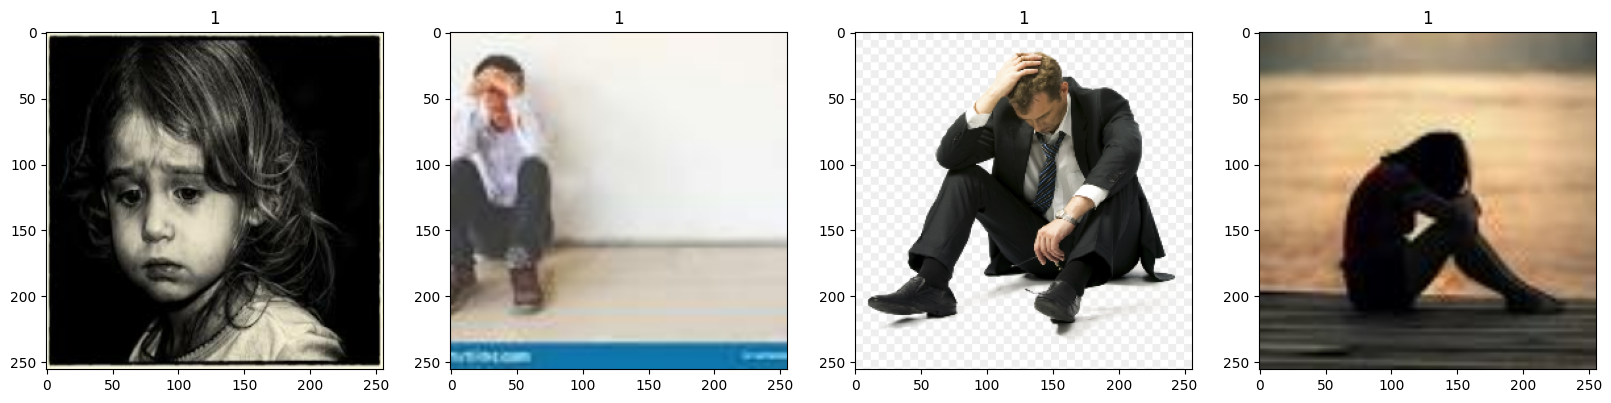

In [64]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [65]:
data = data.map(lambda x,y: (x/255, y))

In [66]:
data.as_numpy_iterator().next()

(array([[[[0.14901961, 0.15686275, 0.14509805],
          [0.14901961, 0.15686275, 0.14509805],
          [0.14901961, 0.15686275, 0.14509805],
          ...,
          [0.21997549, 0.2435049 , 0.22781862],
          [0.22610295, 0.24963236, 0.23394608],
          [0.22745098, 0.2509804 , 0.23529412]],
 
         [[0.14901961, 0.15686275, 0.14509805],
          [0.14901961, 0.15686275, 0.14509805],
          [0.14901961, 0.15686275, 0.14509805],
          ...,
          [0.22106814, 0.24459755, 0.22891128],
          [0.2257475 , 0.2492769 , 0.23359063],
          [0.22677696, 0.25030637, 0.2346201 ]],
 
         [[0.14901961, 0.15686275, 0.14509805],
          [0.14901961, 0.15686275, 0.14509805],
          [0.14901961, 0.15686275, 0.14509805],
          ...,
          [0.22603473, 0.24956414, 0.23387787],
          [0.22413187, 0.24766128, 0.231975  ],
          [0.22371323, 0.24724264, 0.23155637]],
 
         ...,
 
         [[0.02352941, 0.0627451 , 0.05882353],
          [0.02352

# 5. Split Data

In [67]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [68]:
train_size

7

In [69]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [70]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [71]:
from tensorflow.keras.models import Model

In [72]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [73]:
model = Sequential()

In [74]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [75]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [76]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape          ┃      Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)             │ (None, 254, 254, 16)  │          448 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ max_pooling2d_3               │ (None, 127, 127, 16)  │            0 │
│ (MaxPooling2D)                │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ conv2d_5 (Conv2D)             │ (None, 125, 125, 32)  │        4,640 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ max_pooling2d_4               │ (None, 62, 62, 32)    │            0 │
│ (MaxPooling2D)                │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ conv2d_6 (Conv2D)             │ (None, 60, 60, 16)    │        4,624 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ max_pooling2d_5               │ (None, 30, 30, 16)    │            0 │
│ (MaxPooling2D)                │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ flatten_1 (Flatten)           │ (None, 14400)         │            0 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dense_2 (Dense)               │ (None, 256)           │    3,686,656 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dense_3 (Dense)               │ (None, 1)             │          257 │
└───────────────────────────────┴───────────────────────┴──────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

# 7. Train

In [77]:
logdir='logs'

In [78]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [81]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 380ms/step - accuracy: 0.9982 - loss: 0.0030 - val_accuracy: 0.9844 - val_loss: 0.0143
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 380ms/step - accuracy: 0.9952 - loss: 0.0056 - val_accuracy: 0.9844 - val_loss: 0.0131
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 349ms/step - accuracy: 0.9858 - loss: 0.0119 - val_accuracy: 1.0000 - val_loss: 9.3115e-04
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 412ms/step - accuracy: 0.9975 - loss: 0.0052 - val_accuracy: 1.0000 - val_loss: 3.2897e-04
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 362ms/step - accuracy: 1.0000 - loss: 3.2357e-04 - val_accuracy: 1.0000 - val_loss: 4.8856e-04
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 374ms/step - accuracy: 0.9952 - loss: 0.0090 - val_accuracy: 1.0000 - val_loss: 1.8086e-04
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 342ms/step - accuracy: 1.0000 - loss: 1.6101e-04 - val_accuracy: 0.9844 - val_loss: 0.0138
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 373ms/step - accuracy: 1.0000 - loss: 1.6925e-04 - val_

# 8. Plot Performance

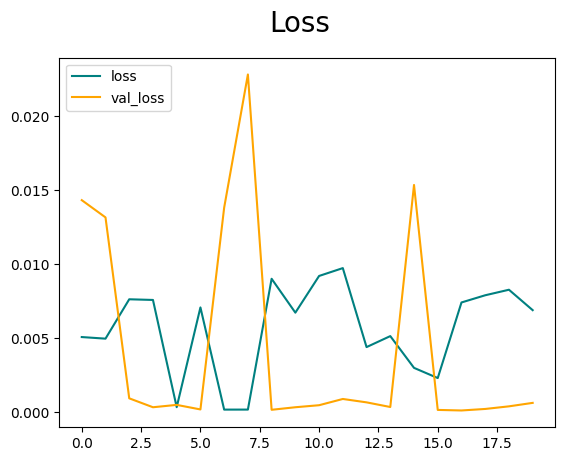

In [82]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

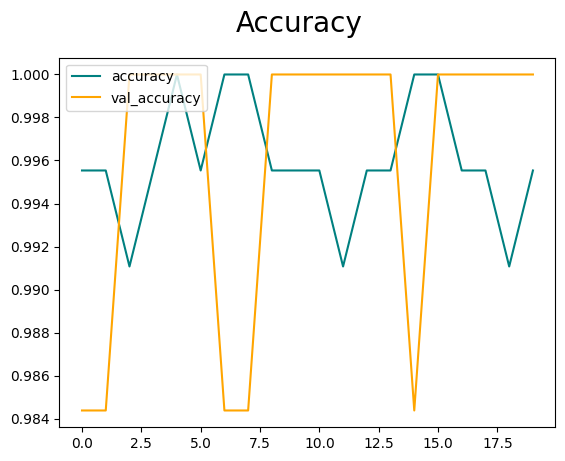

In [83]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [84]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [85]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [86]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


In [87]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


# 10. Test

In [88]:
import cv2

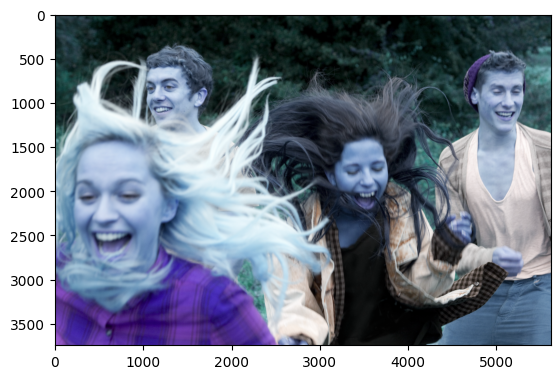

In [90]:
img = cv2.imread('154006829.jpg')
plt.imshow(img)
plt.show()

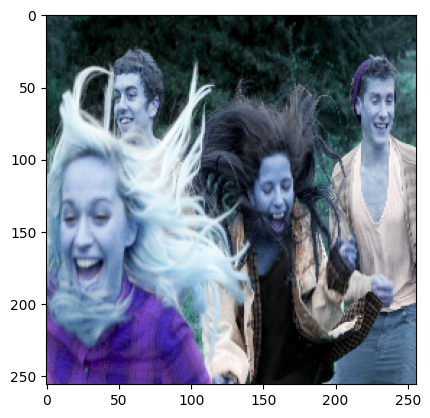

In [95]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [96]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


In [97]:
yhat

array([[0.01047074]], dtype=float32)

In [98]:
if yhat > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Happy


# 11. Save the Model

In [99]:
from tensorflow.keras.models import load_model

In [101]:
model.save(os.path.join('models','imageclassifiernewversionlive.h5'))

In [103]:
new_model = load_model(os.path.join('models','imageclassifiernewversionlive.h5'))

In [104]:
new_model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


array([[0.01047074]], dtype=float32)